In [1]:
#Imports
import sys
import os
import io

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np

import random

import pickle

from ast import literal_eval
from src.model_funcs import run_em, tolerance_sort
from src.plotting_funcs import CB_color_cycle, get_boundaries, plot_ternary_bounds, plot_ternary_axes, plot_bootstrap_bounds
from src.bootstrap_funcs import bootstrap

In [2]:
random.seed(12)
df_snli = pd.read_csv('../data/final/snli-clean.csv', index_col=0)
df_snli.old_labels = df_snli.old_labels.apply(literal_eval) # since quotes in list elements are escaped

In [3]:
#extract relevant columns
snli_one_hot = df_snli[['e', 'n', 'c']]
snli_one_hot_arr = np.array(snli_one_hot).astype(int)

# 1. EM on full dataset, N=1514, J=100

In [4]:
random.seed(12)
snli_em = run_em(snli_one_hot_arr, K=3)

In [5]:
theta, matched_index = tolerance_sort(snli_em[2], 0.05, reverse=True)

pi = snli_em[1][matched_index]
tau = snli_em[3][:, matched_index]
bounds_original = get_boundaries(pi, theta)

In [6]:
recompute = False

if recompute:
    bootstrap_full = bootstrap(snli_one_hot_arr)
    with open("../data/bootstrap/b_full.pkl", "wb") as f:
        pickle.dump(bootstrap_full, f)
else:
    with open("../data/bootstrap/b_full.pkl", "rb") as f:
        bootstrap_full = pickle.load(f)

In [7]:
pi_mean = np.mean(bootstrap_full[('pi')], axis=0)
theta_mean = np.mean(bootstrap_full[('theta')], axis=0)

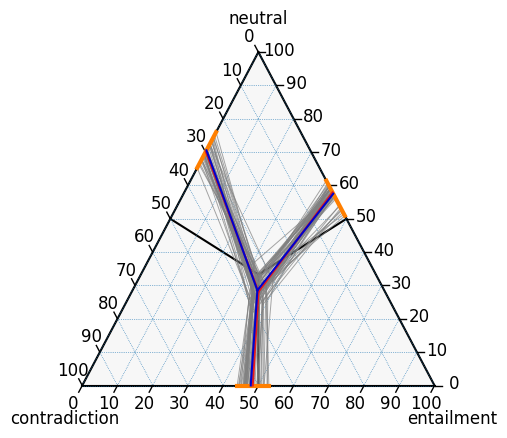

In [8]:
figure, tax = plot_ternary_axes(size=5)
tax = plot_bootstrap_bounds(tax, bootstrap_full['bounds'])
tax = plot_ternary_bounds(tax, pi=pi, theta=theta, bounds_col=CB_color_cycle[7]) # original bounds in red
tax = plot_ternary_bounds(tax, pi=pi_mean, theta=theta_mean, bounds_col="mediumblue") # mean bounds in blue
figure.savefig("../figs/full_bootstrap.png", bbox_inches='tight', dpi=300)

# 1. EM on varying N

In [9]:
recompute = False

if recompute:
    bootstrap_50 = bootstrap(snli_one_hot_arr, N = 50, seed=12)
    with open("../data/bootstrap/b_N_50.pkl", "wb") as f:
        pickle.dump(bootstrap_50, f)
else:
    with open("../data/bootstrap/b_N_50.pkl", "rb") as f:
        bootstrap_50 = pickle.load(f)

In [10]:
pi_mean = np.mean(bootstrap_50[('pi')], axis=0)
theta_mean = np.mean(bootstrap_50[('theta')], axis=0)

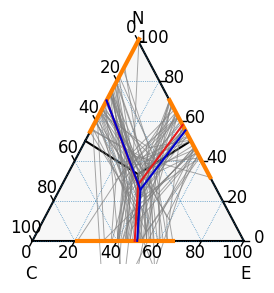

In [11]:
figure, tax = plot_ternary_axes(multiple=20, size=3, labels=["E", "N", "C"], label_offset=-0.15, tick_offset=0.025, weight='roman')
tax = plot_bootstrap_bounds(tax, bootstrap_50['bounds'])
tax = plot_ternary_bounds(tax, pi=pi, theta=theta, bounds_col=CB_color_cycle[7]) # original bounds in red
tax = plot_ternary_bounds(tax, pi=pi_mean, theta=theta_mean, bounds_col="mediumblue") # mean bounds in blue
figure.savefig("../figs/N_50_bootstrap.png", bbox_inches='tight', dpi=300)

In [12]:
def freq_to_matrix(Y):
    mat = np.empty((len(Y),100))
    i=0
    for obs in Y:
        arr = np.empty(100, dtype=int)
        current_index = 0
        for category, count in enumerate(obs):
            arr[current_index:count+current_index] = category
            current_index = count+current_index
        mat[i] = arr
        i=i+1
    return mat

In [13]:
# create matrix with 100 rows for observations 

snli_annotations = np.empty((len(snli_one_hot_arr),100))
i=0
for obs in snli_one_hot_arr:
    arr = np.empty(100, dtype=int)
    current_index = 0
    for category, count in enumerate(obs):
        arr[current_index:count+current_index] = category
        current_index = count+current_index
    snli_annotations[i] = arr
    i=i+1

In [14]:
def N_J_bootstrap_em(N_J_comb, B):

    N = N_J_comb[0]
    J = N_J_comb[1]

    # run bootstrap EM
    B_samples_N_J = []
    B_pi_N_J = []
    B_theta_N_J = []
    B_tau_N_J = []
    B_bounds_N_J = []

    snli_annotations = np.empty((len(snli_one_hot_arr),100))
    i=0
    for obs in snli_one_hot_arr:
        arr = np.empty(100, dtype=int)
        current_index = 0
        for category, count in enumerate(obs):
            arr[current_index:count+current_index] = category
            current_index = count+current_index
        snli_annotations[i] = arr
        i=i+1

    while len(B_pi_N_J) <= B:
        b = len(B_pi_N_J)

        try:

            if b%10 == 0:
                print('Bootstrap iteration: ', b)

            np.random.seed(12+b)

            if J < 100:
                # extract J annotations and turn to one-hot
                random_J = np.random.choice(100, size=J, replace=False)
                annotations_J = snli_annotations[:,random_J].astype(int)

                count_matrix = np.zeros((3, len(annotations_J)), dtype=int)

                for row_idx in range(annotations_J.shape[0]):
                    row = annotations_J[row_idx]
                    unique, counts = np.unique(row, return_counts=True)
                    count_matrix[unique, row_idx] = counts

                snli_one_hot_J = count_matrix.T

            else:
                snli_one_hot_J = snli_one_hot_arr

            # extract bootstrapped observations 
            if N < len(snli_one_hot_J):
                b_sample = np.array(random.choices(snli_one_hot_J, k=N))
                with io.capture_output() as captured:
                    b_snli_em = run_em(b_sample, K=3)

            else:
                b_sample = np.array(random.choices(snli_one_hot_J, k=len(snli_one_hot_J)))
                with io.capture_output() as captured:
                    b_snli_em = run_em(b_sample, K=3)


            # match classes
            matched_index = [x for _, x in sorted(zip(np.argmax(b_snli_em[2],axis=1),np.array([0,1,2])))]
            b_pi_matched = b_snli_em[1][matched_index]
            b_theta_matched = b_snli_em[2][matched_index]  #[:,np.array([1,0,2])]
            b_tau_matched = b_snli_em[3][:, matched_index]
            b_bounds = get_boundaries(b_pi_matched, b_theta_matched)

            # append results to list
            B_samples_N_J.append(b_sample)
            B_pi_N_J.append(b_pi_matched)
            B_theta_N_J.append(b_theta_matched)
            B_tau_N_J.append(b_tau_matched)
            B_bounds_N_J.append(b_bounds)

        except:
            print('Error')

    return B_pi_N_J, B_theta_N_J, B_tau_N_J, B_samples_N_J, B_bounds_N_J, N_J_comb

In [15]:
# N_list = [50, 250, 750, len(snli_one_hot_arr)]
# J_list = [5, 25, 50, 100]
# 
# B_matrix_N_J_random_results_list = []
# B_matrix_N_J_random_mean_bounds = []
# B_matrix_N_J_combinations = []
# 
# for n in N_list:
#     for j in J_list:
#         print('Combination: N=',n, 'J=',j)
#         res = N_J_bootstrap_em(Y= snli_one_hot_arr,N=n, J=j,B=50)
# 
#         pi_mean = np.mean(res[0],axis=0)
#         theta_mean = np.mean(res[1],axis=0)
#         bounds_mean = get_boundaries(pi_mean, theta_mean)
#         
#         B_matrix_N_J_combinations.append((n,j))
#         B_matrix_N_J_random_results_list.append(res)
#         B_matrix_N_J_random_mean_bounds.append(bounds_mean)


In [16]:
N_J_combinations_list = [(50,5), (250,5), (750,5), (len(snli_one_hot_arr),5),
                         (50,25), (250,25), (750,25), (len(snli_one_hot_arr),25),
                         (50,50), (250,50), (750,50), (len(snli_one_hot_arr),50),
                         (50,100), (250,100), (750,100), (len(snli_one_hot_arr), 100)]

B_matrix_N_J_random_results_list = []
B_matrix_N_J_random_mean_bounds = []
B_matrix_N_J_combinations = []



In [ ]:
for comb in N_J_combinations_list:
    print('Combination: ', comb)
    res = N_J_bootstrap_em(N_J_comb = comb,B=50)

    pi_mean = np.mean(res[0],axis=0)
    theta_mean = np.mean(res[1],axis=0)
    bounds_mean = get_boundaries(pi_mean, theta_mean)

    B_matrix_N_J_combinations.append(comb)
    B_matrix_N_J_random_results_list.append(res)
    B_matrix_N_J_random_mean_bounds.append(bounds_mean)

Combination:  (50, 5)
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteration:  0
Error
Bootstrap iteratio